 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 8. Auto Encoder**
# Section 7. Sparse Auto Encoder

### _Objective_
1. Hidden 노드수가 Input 노드 수보다 많은 Overcomplete Auto Encoder에 대해 배워보도록 하겠습니다.<br>
2. Overcomplete Auto Encoder를 학습시키는 대표적인 방법인 Sparse Auto Encoder에 대해 배워보도록 하겠습니다.<br>
  
╚═════════════════════════════════════════╝

In [0]:
%matplotlib inline

import tensorflow as tf
import math
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os

## MNIST 가져오기

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist_data/")

train_images = mnist.train.images
valid_images = mnist.validation.images
test_images = mnist.test.images

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### [Optional.  Tensorflow Graph Visualization ]

---

> _Jupyter에서 Tensorflow에서 구성되는 Graph를 시각적으로 보여주기 위한 helper 메소드입니다._<br>

In [0]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))

    display(HTML(iframe))

<br><br>

# \[ 1. Sparse AutoEncoder란? \]

----

----

> *항상 모든 auto encoder가 bottleneck, 즉 hidden unit이 input unit의 수보다 작을 필요는 없습니다.* <br>
> *hidden Unit이 input unit보다 많은 상황 속에서 이를 학습시키기 위해서는 Sparse Autoencoder의 수식이 필요합니다.*<br>

### (1) OverComplete Code vs Bottleneck Code

![Imgur](https://i.imgur.com/MK10sgt.png)

이전까지 배운 모든 Auto Encoder는 기본적으로 Code가 Input보다 작다고 가정이 되어 있습니다.<br>
Auto Encoder의 Code 수가 Input 수보다 크다면, 사실상 학습할 필요가 없어지기 때문입니다.<br>
왜냐하면, 
$$
x_1=z_1\\
x_2=z_2\\
x_3=z_3\\
x_4=z_4\\
\cdots
$$
이런 방식으로 1대1로 대응시키면 되기 때문입니다.<br>

Code의 수가 Input의 수보다 많은 Overcomplete 상황에서 학습을 시키기 위해서는 <br>
우리는 하나의 제약조건이 필요합니다. <br>
각 Code가 값을 갖는 경우를 한정짓게 만드는 것입니다.

### (2) Sparsity 제약 조건

좋은 특성을 추출하도록 만드는 제약 조건으로서 하나는 바로 희소성, sparsity입니다.<br>
예를 들어, 인코딩 층에서 평균적으로 10% 유닛만 값을 가지도록 강제할 수 있습니다.<br>
그렇게 된다면, 오토인코더는 매번 적은 수의 활성화된 값만을 가지고 decoding을 해야 합니다.<br>
각 뉴런에 대한 평균 활성화 정도를 안다면, 우리는 각 뉴런에 대한 평균 활성화 정도 대비 <br>
지나치게 많이 활성화되거나, 지나치게 활성화가 되지 않은 경우 비용을 줄수 있습니다.

이러한 확률 분포의 차이를 계산하는 방법으로 이전에 배웠던 쿨백 라이블러 발산을 이용할 수 있습니다.

$$
D_{KL}(p||q) = p log \frac{p}{q} + (1-p)log\frac{(1-p)}{(1-q)}
$$

In [0]:
ps = np.arange(0.01,0.99,0.01)
q = 0.3

kld = ps * np.log(ps/q) + (1-ps)*np.log((1-ps)/(1-q))

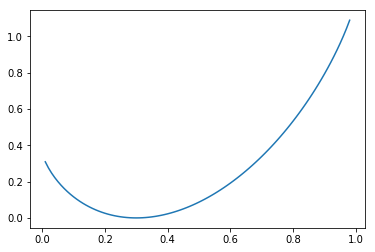

In [0]:
plt.plot(ps,kld)
plt.show()

## 2. Sparse Auto Encoder 구성하기
---


### (1) Graph 구성하기 

중요한 점은 Encoder 할 때, sigmoid를 통해 값의 범위를 0~1, 즉 확률분포로 만들어 주어야 합니다.<br>
이후 KL Diverence를 구할 때, 1보다 크거나 음수가 나오면 log 계산 시 `nan`값이 발생하게 됩니다.<br>

In [0]:
graph = tf.Graph()

num_input = 784
num_hidden1 = 1000

with graph.as_default():
    x = #fix me#
    lr = #fix me #
    
    # code 층의 출력은 0과 1 사이가 되어야 합니다.
    encoded = #fix me# 
    code = tf.identity(encoded, 'code')    
    outputs = #fix me#
    outputs = tf.identity(outputs, 'reconstruction')

In [0]:
show_graph(graph)

### (2) 손실함수 구성하기

우리는 rho_hat, 유닛의 평균 활성화 정도를 10%로 잡았습니다. <br>
$$
D_{KL}(\rho||\hat \rho) = \rho log\frac{\rho}{\hat \rho}+(1-\rho)log\frac{1-\rho}{1-\hat \rho}
$$
우리가 기본적으로 주는 Mean-Squared-Error에 Regularization 수식으로 위를 덧붙이게 됩니다.<br>


In [0]:
alpha = 0.01
with graph.as_default():
    rho_hat = tf.constant(0.1, name='rho_hat')

    with tf.variable_scope("losses"):
        mse = tf.losses.mean_squared_error(x, outputs)
        with tf.variable_scope("kullback-leibler"):
            # 각 배치 중심으로 활성화정도 구하기
            rho = #fix me #
            kld = #fix me # 쿨백 라이블러 발산 구하기 
        loss = # fix me # 

        with tf.variable_scope('metric'):
            rmse = #fix me #

        with tf.variable_scope('train'):
            train_op = #fix me#

In [0]:
show_graph(graph)

### (3) 학습시키기

In [0]:
num_epoch = 20 # epoch 횟수
num_batch = 128 # 배치 크기
num_data = mnist.train.num_examples # data의 수
num_step = num_data // num_batch # 1 epoch 별 학습 횟수

with graph.as_default():
    sess = tf.Session(graph=graph)
    
    sess.run(tf.global_variables_initializer())
    for i in range(num_epoch):        
        for _ in range(num_step):
            images, _ = #fix me #
            sess.run(#fix me#)
        
        rmse_value = sess.run(#fix me#)
        print("{:2d}th epoch test RMSE : {:.5f}".format(i,rmse_value))

 0th epoch test RMSE : 0.21208
 1th epoch test RMSE : 0.16278
 2th epoch test RMSE : 0.13761
 3th epoch test RMSE : 0.12282
 4th epoch test RMSE : 0.11406
 5th epoch test RMSE : 0.10617
 6th epoch test RMSE : 0.10082
 7th epoch test RMSE : 0.09612
 8th epoch test RMSE : 0.09185
 9th epoch test RMSE : 0.09027
10th epoch test RMSE : 0.08692
11th epoch test RMSE : 0.08252
12th epoch test RMSE : 0.08026
13th epoch test RMSE : 0.07820
14th epoch test RMSE : 0.07512
15th epoch test RMSE : 0.07388
16th epoch test RMSE : 0.07197
17th epoch test RMSE : 0.06976
18th epoch test RMSE : 0.06726
19th epoch test RMSE : 0.06773


### (3) 결과 확인하기

재구축된 이미지와 원래 이미지를 비교해 보도록 하겠습니다.

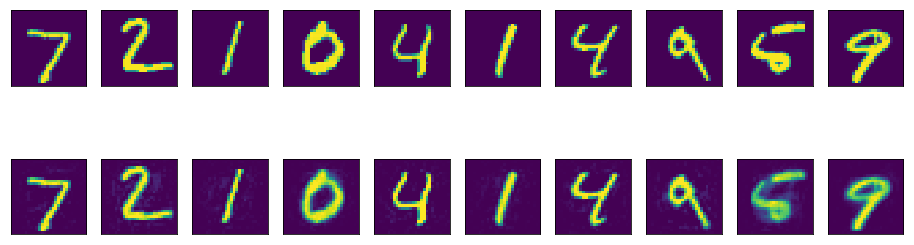

In [0]:
reconstruction = sess.run(#fix me#)
reconstruction = np.clip(#fix me #) # 0~1 사이로 clipping 합니다.
reconstruction = reconstruction.reshape(# fix me 이미지의 모양으로 reshape 합니다 )

fig, (ax1, ax2) = plt.subplots(2,10, figsize=(16,5))

for i in range(10):
    ax = ax1[i]
    ax.set_xticks([])
    ax.set_yticks([])    
    ax.imshow(test_images[i].reshape(28,28))
    
for i in range(10):
    ax = ax2[i]
    ax.set_xticks([])
    ax.set_yticks([])    
    ax.imshow(reconstruction[i])

plt.show()

### (4) code 층의 값 확인하기

Code 층의 각 unit의 값이 0.1에 머물고 있음을 확인할 수 있습니다.

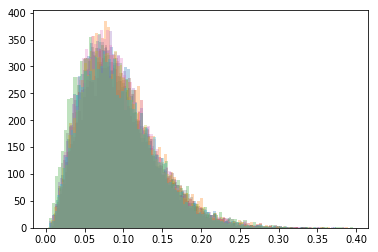

In [0]:
code_value = sess.run(# fix me)

for i in range(10):
    plt.hist(code_value[:,i],bins=100,alpha=0.3)
plt.show()

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/14

---